<a href="https://colab.research.google.com/github/neworderofjamie/riscv_ise/blob/master/tutorials/poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are lots of rough edges here: error checking is lacking in places, the compiler supports an even smaller subset of C than it should and the wrapping of various bits of API is not very Pythonic.

# Installation
The current prototype FeNN toolchain is a little bit tricky to build as it re-uses parts of GeNN (mostly the type system and the GeNNCode scanner, parser and type checker) so, on colab, we can install a prebuilt wheel from my google drive:

In [4]:
if "google.colab" in str(get_ipython()):
    !gdown 1aO3CLhWJeoDXJ-lb7FqrtxDy-7WRsNYK
    !pip install pyfenn-0.0.1-cp312-cp312-linux_x86_64.whl

Downloading...
From: https://drive.google.com/uc?id=1aO3CLhWJeoDXJ-lb7FqrtxDy-7WRsNYK
To: /content/pyfenn-0.0.1-cp312-cp312-linux_x86_64.whl
100% 6.55M/6.55M [00:00<00:00, 10.0MB/s]
Processing ./pyfenn-0.0.1-cp312-cp312-linux_x86_64.whl
pyfenn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from pyfenn import (BackendFeNNSim, Model, NeuronUpdateProcess, Parameter,
                    ProcessGroup, RNGInitProcess, Runtime, Variable)

from pyfenn import disassemble, init_logging
from pyfenn.models import RNGInit
from pyfenn.utils import get_array_view, seed_and_push
from scipy.stats import poisson

# Parameters
Define how many samples we want each poisson generator to sample at what rate:

In [33]:
num_samples = 100
shape = 32
rate = 5000.0

# Layer classes
FeNN is programmed using a small number of primitive objects:
*   ``Processes`` perform computation
*   ``Variables`` are used to hold model state e.g. neuron variables and weights
*   ``EventContainers`` are the primary means of communication between neuron processes

The FeNN tools don't really enforce any particular style of modelling but you can easily use these primitives to create PyTorchesque layer objects. We start by creating a leaky integrator for the output layer. This integrates an input current + bias into a membrane voltage which is averaged over the trial. The update to be performed each timestep is implemented in a ``NeuronUpdateProcess`` which performs the same update to each neuron (as dictated by the same of the variables). In future, these processes might be Just-in-Time compiled from Python but, right now, they are implemented in [GeNNCode](https://genn-team.github.io/genn/documentation/5/custom_models.html#genncode). This is basically a subset of C with extensions for fixed-point types inspired by the [ISO standard extension](https://www.open-std.org/jtc1/sc22/wg14/www/docs/n1005.pdf). Here we define a Poisson generator using Knuth's algorithm (https://www.johndcook.com/blog/2010/06/14/generating-poisson-random-values/). Fixed-point types are specified as strings, for example s1_14_t is a signed 16-bit fixed point type (this is all FeNN currently supports) with 1 integer and 14 fractional bits. The ``fennrand()`` function will genrate a random number :

In [21]:
class Poisson:
    def __init__(self, shape, num_samples: int, rate: float):
        self.shape = shape
        self.num_spikes = Variable(self.shape, "int16_t", num_samples + 1)

        self.process = NeuronUpdateProcess(
            """
            s1_14_t p = 1.0h14;
            NumSpikes = 0;
            do
            {
                ++NumSpikes;
                p *= fennrand();
            } while (p > ExpMinusLambda);
            --NumSpikes;
            """,
            {"ExpMinusLambda": Parameter(np.exp(-(rate / 1000)), "s1_14_t")},
            {"NumSpikes": self.num_spikes},
            {})


# Model definition
The FeNN tools can produce lots of helpful logging information so we initialise this system before we do anything else (if you use ``from pyfenn import PlogSeverity`` to import the enum you can then use e.g. ``PlogSeverity.DEBUG`` to control the logging level):

In [7]:
init_logging()

Then create a RNG initialisation process and one of the Poisson layers we defined above:

In [22]:
rng_init = RNGInit()
poisson_process = Poisson(shape, num_samples, rate)

Process groups define computation that can be performed in parallel (in fact, on FeNN it's not but this won't be the case with e.g. GPU backends) so we group our initialisation and update processes into seperate groups

In [23]:
init_processes = ProcessGroup([rng_init.process])
update_processes = ProcessGroup([poisson_process.process])

# Simulation
Sadly Google has yet to install FeNN nodes into it's cloud so for now we create a simulation backend (if you are lucky enough to be running on a Kria KV260 with the bitstream loaded, you should substitute ``BackendFeNNHW`` here) and use it to create a generic simulation kernel. The control flow of these kernels *will* be fully programmable but for now you can either create a really simple kernel which just runs a list of process groups or a 'simulation' kernel which offloads running a loop over time with a list of process groups in the body and another list that runs at the end (which we use here to copy output classifications off of FeNN). Here we generate both types of a kernel: a simple one to initialise the RNG and a simulation one to generate Poisson samples in a loop:

In [13]:
backend = BackendFeNNSim()

Now we define a model which groups together all parts of our simulation:

In [24]:
model = Model([init_processes, update_processes], backend)

In [25]:
code = backend.generate_simulation_kernel([update_processes],
                                          [init_processes], [],
                                          num_samples, model)

Now we have some code, we create a ``Runtime`` object to interact with the FeNN. We first use this to allocate the memory required for our model on FeNN:

In [26]:
runtime = Runtime(model, backend)
runtime.allocate()

Now we use some helper functions to copy some randomness into the RNG seed:


In [27]:
seed_and_push(rng_init.seed, runtime)

then, swap it out for the simulation code:

In [28]:
runtime.set_instructions(code)

and finally we run our kernel:

In [29]:
runtime.run()

Having filled up all of FeNN's memory with samples, we now want to access them! The ``Runtime`` object creates a bunch of 'Array' objects which are used to interact with model state so we first get them from the neuron update processes and copy their contents to the host:

In [34]:
num_spikes_array, num_spikes_view = get_array_view(runtime, poisson_process.num_spikes,
                                                   np.int16, (num_samples + 1, shape))
num_spikes_array.pull_from_device()

Finally, we can plot a histrogram of our samples

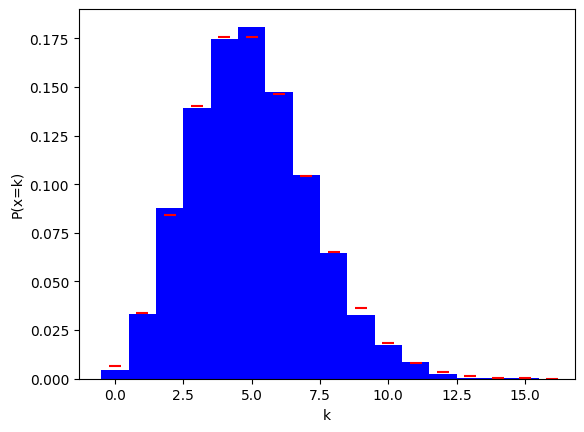

In [35]:
num_spikes_view = num_spikes_view[1:,:].flatten()
x = np.arange(np.amin(num_spikes_view), 1 + np.amax(num_spikes_view))

fig, axis = plt.subplots()
axis.hist(num_spikes_view, bins=x - 0.5, density=True, color="blue")
axis.scatter(x, poisson.pmf(x, rate / 1000.0), marker="_", s=75, color="red")
axis.set_xlabel("k")
axis.set_ylabel("P(x=k)")
plt.show()

# Disassembling 😥
Sometimes it's cool to know what's happening under the hood so, by using the ``disassemble`` function you can disassemble the code produced be the backend into a slightly friendly form. A slightly outdated description of the instruction set is provided at https://github.com/neworderofjamie/riscv_ise/blob/master/docs/instruction_set.pdf

In [ ]:
for i, c in enumerate(code):
    print(f"{i * 4} : {disassemble(c)}")

0 : ADDI X1, X0, 0
4 : ADDI X2, X0, 100
8 : VLUI V1, 0
12 : VLUI V0, 16384
16 : LW X4, 8(X0)
20 : VLUI V2, 110
24 : VLOAD V3, 0(X4)
28 : ADDI X0, X0, 0
32 : VADD V4, V0, V1
36 : VADD V3, V1, V1
40 : ADDI X3, X0, -1
44 : VLUI V6, 1
48 : VADD V5, V3, V6
52 : VSEL V3, X3, V5
56 : VRNG V5
60 : VMUL V6, V4, V5, 15
64 : VSEL V4, X3, V6
68 : VTLT X5, V2, V4
72 : AND X3, X3, X5
76 : BNE X3, X0, -32
80 : VLUI V5, 1
84 : VSUB V3, V3, V5
88 : VSTORE V3, 0(X4)
92 : LW X4, 12(X0)
96 : LW X3, 16(X0)
100 : ADDI X6, X0, 64
104 : ADD X5, X4, X6
108 : MUL X7, X1, X6
112 : ADD X3, X3, X7
116 : VLOAD V0, 0(X4)
120 : ADDI X0, X0, 0
124 : VEXTRACT X6, V0, 0
128 : SH X6, 0(X3)
132 : VEXTRACT X6, V0, 1
136 : SH X6, 2(X3)
140 : VEXTRACT X6, V0, 2
144 : SH X6, 4(X3)
148 : VEXTRACT X6, V0, 3
152 : SH X6, 6(X3)
156 : VEXTRACT X6, V0, 4
160 : SH X6, 8(X3)
164 : VEXTRACT X6, V0, 5
168 : SH X6, 10(X3)
172 : VEXTRACT X6, V0, 6
176 : SH X6, 12(X3)
180 : VEXTRACT X6, V0, 7
184 : SH X6, 14(X3)
188 : VEXTRACT X6, V0, 8
1